# Deep Learning for NLP - Project

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [1]:
import io
import os
import numpy as np
import scipy

In [2]:
PATH_TO_DATA = "data/"

# 1) Monolingual (English) word embeddings 

In [3]:
class Word2vec():
    def __init__(self, fname, nmax=100000):
        self.load_wordvec(fname, nmax)
#         self.word2id = dict.fromkeys(self.word2vec.keys(),np.arange(nmax))
        self.word2id = {i:list(self.word2vec.keys()).index(i) for i in self.word2vec.keys()}
        self.id2word = {v: k for k, v in self.word2id.items()}
        self.embeddings = list(self.word2vec.values())
    
    def load_wordvec(self, fname, nmax):
        self.word2vec = {}
        with io.open(fname, encoding='utf-8') as f:
            next(f)
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                self.word2vec[word] = np.fromstring(vec, sep=' ')
                if i == (nmax - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(self.word2vec)))

    def most_similar(self, w, K=5):
        # K most similar words: self.score  -  np.argsort 
        scores = np.array([self.score(w,w_) for w_ in self.word2vec.keys()])
        best_scores = np.argsort(1-scores)[1:K+1] #We remove the first element because it corresponds to w
        return [self.id2word[id_] for id_ in best_scores]

    def score(self, w1, w2):
        # cosine similarity: np.dot  -  np.linalg.norm
        w1_ = w2v.embeddings[w2v.word2id[w1]]
        w2_ = w2v.embeddings[w2v.word2id[w2]]
        return np.dot(w1_,w2_)/(np.linalg.norm(w1_)*(np.linalg.norm(w2_)))

In [4]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=25000)

# You will be evaluated on the output of the following:
for w1, w2 in zip(('cat', 'dog', 'dogs', 'Paris', 'Germany'), ('dog', 'pet', 'cats', 'France', 'Berlin')):
    print(w1, w2, w2v.score(w1, w2))
for w1 in ['cat', 'dog', 'dogs', 'Paris', 'Germany']:
    print(w2v.most_similar(w1))

Loaded 25000 pretrained word vectors
cat dog 0.671683666279249
dog pet 0.6842064029669219
dogs cats 0.7074389328052404
Paris France 0.7058595452409975
Germany Berlin 0.7060253015336013
['cats', 'kitty', 'kitten', 'Cat', 'dog']
['dogs', 'puppy', 'Dog', 'canine', 'pup']
['dog', 'Dogs', 'puppies', 'cats', 'canine']
['Parisian', 'France', 'Versailles', 'Lyon', 'Bordeaux']
['Austria', 'Bavaria', 'Berlin', 'Munich', 'German']


In [5]:
class BoV():
    def __init__(self, w2v):
        self.w2v = w2v
    
    def encode(self, sentences, idf=False):
        # takes a list of sentences, outputs a numpy array of sentence embeddings
        # see TP1 for help
        sentemb = []
        ind_nan = []
        for idx,sent in enumerate(sentences):
            if idf is False:
                # mean of word vectors
                tmp = sent.split(' ')
                mean_vector = np.mean([w2v.embeddings[w2v.word2id[w]] for w in tmp
                                        if w in self.w2v.word2vec.keys()],axis=0)
                if np.isnan(mean_vector).any() == False:
                    sentemb.append(mean_vector)
                else:
                    ind_nan.append(idx)

            else:
                # idf-weighted mean of word vectors
                tmp = sent.split(' ')
                weights = [idf[w] for w in tmp if w in self.w2v.word2vec.keys()]
                #np.ma.average is more robust. returns nan when sum of weights is 0
                avg_vector = np.ma.average([w2v.embeddings[w2v.word2id[w]] for w in tmp
                                           if w in self.w2v.word2vec.keys()],axis = 0,
                                           weights = weights)
                if np.isnan(avg_vector).any() == False:
                    sentemb.append(avg_vector)
                else:
                    ind_nan.append(idx)
        
        return np.array(sentemb),np.array(ind_nan)

    def most_similar(self, s, sentences, idf=False, K=5):
        # get most similar sentences and **print** them
#         keys = self.encode(sentences, idf)
#         query = self.encode([s], idf)
        
        scores = np.array([self.score(s,sent) for sent in sentences])
        best_scores = np.argsort(1-scores)[1:K+1] #We remove the first element because it corresponds to s
        
        return [sentences[id_] for id_ in best_scores]

    def score(self, s1, s2, idf=False):
        # cosine similarity: use   np.dot  and  np.linalg.norm
        s1_,_ = self.encode([s1], idf)
        s2_,_ = self.encode([s2], idf)
        if len(s1_) == 0 or len(s2_) == 0:
            return -np.inf
        else:
            s1_ = s1_[0]
            s2_ = s2_[0]
        return np.dot(s1_,s2_)/(np.linalg.norm(s1_)*(np.linalg.norm(s2_)))        
    
    def build_idf(self, sentences):
        # build the idf dictionary: associate each word to its idf value
        idf = {}
        for sent in sentences:
            for w in sent.split(' '):
                idf[w] = idf.get(w, 0) + 1
        for word in idf.keys():
            idf[word] = max(1, np.log10(len(sentences) / (idf[word])))
        return idf

In [6]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=5000)
s2v = BoV(w2v)

# Load sentences in "PATH_TO_DATA/sentences.txt"
sentences = []
f = open(os.path.join(PATH_TO_DATA, 'sentences.txt'), "r")

for line in f:
    sentences.append(line.split('\n')[0])

# You will be evaluated on the output of the following:
print('The most similar sentences to ','' if not sentences else sentences[10],'are',s2v.most_similar('' if not sentences 
                      else sentences[10], sentences))  # BoV-mean
print('The similarity between #','' if not sentences else sentences[7],'and #','' if not sentences else 
                      sentences[13],s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13]))

# Build idf scores for each word
idf = s2v.build_idf(sentences) 
print('The most similar sentences to ','' if not sentences else sentences[10],'are',s2v.most_similar('' if not sentences
                      else sentences[10], sentences, idf))  # BoV-idf
print('The similarity between #','' if not sentences else sentences[7],'and #','' if not sentences else
                      sentences[13],s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13],idf))

Loaded 5000 pretrained word vectors


/home/idriss_mg/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idriss_mg/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


The most similar sentences to  1 smiling african american boy .  are ['blond boy waterskiing . ', 'a boy skateboarding . ', 'a boy smiles underwater . ', 'a boy jumps . ', 'a boy screams . ']
The similarity between # 1 man singing and 1 man playing a saxophone in a concert .  and # 10 people venture out to go crosscountry skiing .  0.6089445116147133
The most similar sentences to  1 smiling african american boy .  are ['blond boy waterskiing . ', 'a boy skateboarding . ', 'a boy smiles underwater . ', 'a boy jumps . ', 'a boy screams . ']
The similarity between # 1 man singing and 1 man playing a saxophone in a concert .  and # 10 people venture out to go crosscountry skiing .  0.5960612293693168


# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [9]:
# 1 - Download and load 50k first vectors of
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.vec
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.vec

# TYPE CODE HERE
def load_wordvec(fname, nmax):
    word2vec = {}
    with io.open(fname, encoding='utf-8') as f:
        next(f)
        for i, line in enumerate(f):
            word, vec = line.split(' ', 1)
            word2vec[word] = np.fromstring(vec, sep=' ')
            if i == (nmax - 1):
                break
    return word2vec
    
word2vec_en = load_wordvec(os.path.join(PATH_TO_DATA, 'wiki.en.vec'),nmax = 25000)
word2vec_fr = load_wordvec(os.path.join(PATH_TO_DATA, 'wiki.fr.vec'),nmax = 25000)

In [23]:
# 2 - Get words that appear in both vocabs (= identical character strings)
#     Use it to create the matrix X and Y (of aligned embeddings for these words)

en_keys = list(word2vec_en.keys())
fr_keys = list(word2vec_fr.keys())

common_keys = list(set(en_keys) & set(fr_keys))

X = np.array([word2vec_fr[key] for key in common_keys]).T
Y = np.array([word2vec_en[key] for key in common_keys]).T

In [30]:
# 3 - Solve the Procrustes using the scipy package and: scipy.linalg.svd() and get the optimal W
#     Now W*French_vector is in the same space as English_vector

M = Y@(X.T)

U,S,V = np.linalg.svd(M)

W = U@V #W is of shape (300,300)

In [46]:
# 4 - After alignment with W, give examples of English nearest neighbors of some French words (and vice versa)
#     You will be evaluated on that part and the code above

french_word1 = 'mer'
f_word_emb1  = W.dot(word2vec_fr[french_word1])

scores_fr_en = np.array([custom_metric(f_word_emb1,word2vec_en[key]) for key in word2vec_en.keys()])

english_word1 = [list(word2vec_en.keys())[i] for i in np.argsort(scores_fr_en)[:6]]

print('the english words {} correspond to the french word {}'.format(english_word1,french_word1))

french_word2 = 'chat'
f_word_emb2  = W.dot(word2vec_fr[french_word2])

scores_fr_en = np.array([custom_metric(f_word_emb2,word2vec_en[key]) for key in word2vec_en.keys()])

english_word2 = [list(word2vec_en.keys())[i] for i in np.argsort(scores_fr_en)[:6]]

print('the english words {} correspond to the french word {}'.format(english_word2,french_word2))

english_word1 = 'sky'
e_word_emb1  = (W.T).dot(word2vec_en[english_word1])

scores_en_fr = np.array([custom_metric(e_word_emb1,word2vec_fr[key]) for key in word2vec_fr.keys()])

french_word1 = [list(word2vec_fr.keys())[i] for i in np.argsort(scores_en_fr)[:6]]

print('the french words {} correspond to the english word {}'.format(french_word1,english_word1))


the english words ['sea', 'coastline', 'mer', 'coasts', 'shore', 'seas'] correspond to the french word mer
the english words ['cat', 'rabbit', 'squirrel', 'dog', 'rat', 'rabbits'] correspond to the french word chat
the french words ['sky', 'earth', 'bird', 'blue', 'ciel', 'horizon'] correspond to the english word sky


If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [87]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)

def load_sentences(filename):
    sentences = []
    labels = []
    f = open(os.path.join(PATH_TO_DATA, filename), "r")
    if 'test' in filename:
        for line in f:
            sentences.append(line.split('\n')[0][2:])
        return sentences
    else:
        for line in f:
            sentences.append(line.split('\n')[0][2:])
            labels.append(int(line.split('\n')[0][0]))
        return sentences,np.array(labels)

sentences_dev,labels_dev = load_sentences('SST/stsa.fine.dev')
sentences_train,labels_train = load_sentences('SST/stsa.fine.train')
sentences_test = load_sentences('SST/stsa.fine.test.X')

In [76]:
# 2 - Encode sentences with the BoV model above
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=5000)
s2v = BoV(w2v)

"""
Mean encoding
"""
dev_emb,ind_nan_dev = s2v.encode(sentences_dev,idf=False)
train_emb,ind_nan_train = s2v.encode(sentences_train,idf=False)
test_emb,_ = s2v.encode(sentences_test,idf=False)

"""
Weighted average encoding
"""
idf = s2v.build_idf(sentences_dev) 
dev_emb_idf,_ = s2v.encode(sentences_dev,idf=idf) 
#ind_nan_XXX_idf is equal to ind_nan_XXX because the same elements are nan

idf = s2v.build_idf(sentences_train) 
train_emb_idf,_ = s2v.encode(sentences_train,idf=idf)

idf = s2v.build_idf(sentences_test) 
test_emb_idf,_ = s2v.encode(sentences_test,idf=idf)

Loaded 5000 pretrained word vectors


In [96]:
# # 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
# #     (consider tuning the L2 regularization on the dev set)
import warnings 
warnings.filterwarnings("ignore")

sentences_dev,labels_dev = load_sentences('SST/stsa.fine.dev')
sentences_train,labels_train = load_sentences('SST/stsa.fine.train')

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ParameterSampler,ParameterGrid
    
if len(ind_nan_train) != 0 :
    nan_mask = np.ones(len(labels_train),dtype=bool)
    nan_mask[ind_nan_train] = False
    labels_train = labels_train[nan_mask]

if len(ind_nan_dev) != 0:
    nan_mask = np.ones(len(labels_dev),dtype=bool)
    nan_mask[ind_nan_dev] = False
    labels_dev = labels_dev[nan_mask]

param_grid = {'C':[2**n for n in [-1,0,1,2,3,4,5,6,7]]}
param_list = list(ParameterGrid(param_grid))

logreg = LogisticRegression(penalty = 'l2',multi_class='auto')

def evaluate_prediction(clf,param_list,x_train,y_train,x_val,y_val):
    """
    clf: (object) classifier
    param_list: (dict) parameters of the classifier
    """
    accuracy_train = []
    accuracy_val   = []
    for params in param_list:
        if hasattr(clf,'set_params'):
            clf = clf.set_params(**params)
        else:
            raise ValueError('The attribute "set_params" is not defined for the chosen classifier')

        clf.fit(x_train,y_train)
        output_train = clf.predict(x_train)
        accuracy_train.append(accuracy_score(output_train,y_train))

        output = clf.predict(x_val)
        accuracy_val.append(accuracy_score(output,y_val))
        
    return accuracy_train,accuracy_val

acc_train,acc_val = evaluate_prediction(logreg,param_list,train_emb,labels_train,dev_emb,labels_dev)
print('The best validation score is ',np.max(acc_val))
print('The training score corresponding is ', acc_train[np.argmax(acc_val)])

acc_train_idf,acc_val_idf = evaluate_prediction(logreg,param_list,train_emb_idf,labels_train,dev_emb_idf,labels_dev)
print('The best validation score when using idf is ',np.max(acc_val_idf))
print('The training score corresponding is ', acc_train_idf[np.argmax(acc_val_idf)])

The best validation score is  0.38782924613987285
The training score corresponding is  0.4213792295984077
The best validation score when using idf is  0.3851044504995459
The training score corresponding is  0.43414120126448896


In [99]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.

# Using the mean BOV instead of the weighted average yields better results
clf = LogisticRegression(penalty='l2')
clf = clf.set_params(**param_list[np.argmax(acc_val)])

clf.fit(train_emb,labels_train)

output = clf.predict(test_emb)

file = open(os.path.join(PATH_TO_DATA, "logreg_bov_y_test_sst.txt"),"w") 
for elem in output:
    file.write(str(elem)+'\n')
file.close()

In [104]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)

from xgboost import XGBClassifier

param_grid = {'n_estimators': [100,150,200,300],'max_depth': [3,5,7],'learning_rate' : [0.01,0.03,0.05,0.1],
              'colsample_bylevel':[0.7,0.8,0.9,1],'objective':['multi:softmax']}
n_iter = 5
param_list_xgb = list(ParameterSampler(param_grid, n_iter=n_iter,random_state = 42))

xgb = XGBClassifier(n_jobs = -1)
acc_train_xgb,acc_val_xgb = evaluate_prediction(xgb,param_list_xgb,train_emb,labels_train,dev_emb,labels_dev)
print('The best validation score is ',np.max(acc_val_xgb))
print('The training score corresponding is ', acc_train_xgb[np.argmax(acc_val_xgb)])

xgb = XGBClassifier(n_jobs = -1)
acc_train_idf_xgb,acc_val_idf_xgb = evaluate_prediction(xgb,param_list_xgb,train_emb_idf,labels_train,dev_emb_idf,labels_dev)
print('The best validation score when using idf is ',np.max(acc_val_idf_xgb))
print('The training score corresponding is ', acc_train_idf_xgb[np.argmax(acc_val_idf_xgb)])


if np.max(acc_val_xgb) > np.max(acc_val_idf_xgb):
    print('Using mean BOV is better than using IDF')
    best_xgb = XGBClassifier(n_jobs = -1).set_params(**param_list_xgb[np.argmax(acc_val_xgb)])
    best_xgb.fit(train_emb,labels_train)
    
    output_xgb = best_xgb.predict(test_emb)

    file = open(os.path.join(PATH_TO_DATA, "XGB_bov_y_test_sst.txt"),"w") 
    for elem in output_xgb:
        file.write(str(elem)+'\n')
    file.close()
else:
    print('Using IDF is better than using mean BOV')
    best_xgb = XGBClassifier(n_jobs = -1).set_params(**param_list_xgb[np.argmax(acc_val_idf_xgb)])
    
    best_xgb.fit(train_emb_idf,labels_train)

    output_xgb = best_xgb.predict(test_emb_idf)

    file = open(os.path.join(PATH_TO_DATA, "XGB_bov_y_test_sst.txt"),"w") 
    for elem in output_xgb:
        file.write(str(elem)+'\n')
    file.close()

The best validation score is  0.37693006357856496
The training score corresponding is  0.9878234398782344
The best validation score when using idf is  0.37057220708446864
The training score corresponding is  0.9878234398782344
Using mean BOV is better than using IDF


# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [3]:
import keras

Using TensorFlow backend.


In [4]:
# 1 - Load train/dev/test sets of SST
PATH_TO_DATA = "data/"

def load_sentences(filename):
    sentences = []
    labels = []
    f = open(os.path.join(PATH_TO_DATA, filename), "r")
    if 'test' in filename:
        for line in f:
            sentences.append(line.split('\n')[0][2:])
        return sentences
    else:
        for line in f:
            sentences.append(line.split('\n')[0][2:])
            labels.append(int(line.split('\n')[0][0]))
        return sentences,np.array(labels)

x_dev,y_dev = load_sentences('SST/stsa.fine.dev')
x_train,y_train = load_sentences('SST/stsa.fine.train')
x_test = load_sentences('SST/stsa.fine.test.X')

In [5]:
# 2 - Transform text to integers using keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/

from keras.utils import to_categorical

y_train = to_categorical(y_train)
y_dev   = to_categorical(y_dev)

from keras.preprocessing import text

all_sentences = x_train + x_dev + x_test

vocabulary = set([w for sent in all_sentences for w in sent.split()])
MAX_SENT   = np.max([len(sent.split(' ')) for sent in all_sentences])
VOCAB_SIZE = len(vocabulary)

x_train_oh = [text.one_hot(elem,VOCAB_SIZE) for elem in x_train]
x_dev_oh   = [text.one_hot(elem,VOCAB_SIZE) for elem in x_dev]
x_test_oh  = [text.one_hot(elem,VOCAB_SIZE) for elem in x_test]

**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [7]:
# 3 - Pad your sequences using keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/

from keras.preprocessing.sequence import pad_sequences

x_train_pad = pad_sequences(x_train_oh, maxlen=MAX_SENT)
x_dev_pad = pad_sequences(x_dev_oh, maxlen=MAX_SENT)
x_test_pad = pad_sequences(x_test_oh,maxlen=MAX_SENT)

## 4.2 - Design and train your model

In [41]:
# 4 - Design your encoder + classifier using keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this contained : the lookuptable, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.


from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Activation
from keras import regularizers
from keras.callbacks import ModelCheckpoint,EarlyStopping

embed_dim  = 300  # word embedding dimension
nhid       = 64  # number of hidden units in the LSTM
n_classes  = 5

model = Sequential()
model.add(Embedding(VOCAB_SIZE, embed_dim))
model.add(LSTM(nhid, dropout=0.5, recurrent_dropout=0.3, kernel_regularizer = regularizers.l2(0.1)))
model.add(Dense(n_classes, activation='softmax'))

In [42]:
# 5 - Define your loss/optimizer/metrics

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'Adam' # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 300)         5982300   
_________________________________________________________________
lstm_10 (LSTM)               (None, 64)                93440     
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 325       
Total params: 6,076,065
Trainable params: 6,076,065
Non-trainable params: 0
_________________________________________________________________
None


/home/idriss_mg/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/home/idriss_mg/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:20: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 8544 samples, validate on 1101 samples
Epoch 1/40
8544/8544 [==============================] - 21s 2ms/step - loss: 12.9976 - acc: 0.2677 - val_loss: 4.1040 - val_acc: 0.2534

Epoch 00001: saving model to weights_LSTM-01-0.25.hdf5
Epoch 2/40
8544/8544 [==============================] - 18s 2ms/step - loss: 2.3975 - acc: 0.2979 - val_loss: 1.6785 - val_acc: 0.2534

Epoch 00002: saving model to weights_LSTM-02-0.25.hdf5
Epoch 3/40
8544/8544 [==============================] - 18s 2ms/step - loss: 1.5928 - acc: 0.2999 - val_loss: 1.5722 - val_acc: 0.2879

Epoch 00003: saving model to weights_LSTM-03-0.29.hdf5
Epoch 4/40
8544/8544 [==============================] - 18s 2ms/step - loss: 1.5387 - acc: 0.3422 - val_loss: 1.4995 - val_acc: 0.3697

Epoch 00004: saving model to weights_LSTM-04-0.37.hdf5
Epoch 5/40
8544/8544 [==============================] - 18s 2ms/step - loss: 1.4266 - acc: 0.4143 - val_loss: 1.4584 - val_acc: 0.3933

Epoch 00005: saving model to weights_LSTM-05-0.39.h

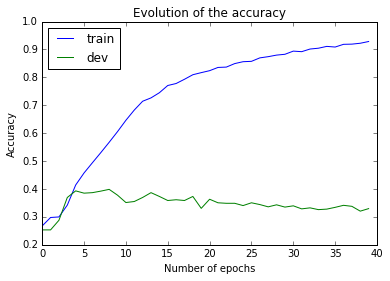

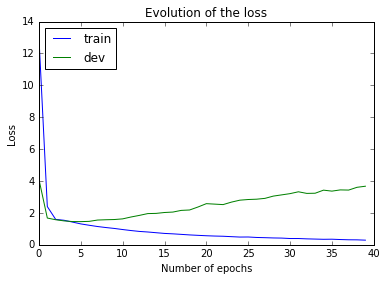

In [43]:
# 6 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set

import matplotlib
%matplotlib inline
matplotlib.use('agg')

from matplotlib import pyplot as plt

# ADAPT CODE BELOW
bs = 128
n_epochs = 40

#Checkpoint
filepath="weights_LSTM-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=False, mode='max')
callbacks_list = [checkpoint]

history = model.fit(x_train_pad, y_train, batch_size=bs, nb_epoch=n_epochs,callbacks = callbacks_list,
                    validation_data=(x_dev_pad, y_dev))

"""
Accuracy plots
"""

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.title('Evolution of the accuracy')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

"""
Loss plots
"""

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.title('Evolution of the loss')
plt.legend(['train', 'dev'], loc='upper left')

In [44]:
# 7 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.

model.load_weights("weights_LSTM-18-0.36.hdf5")
output = model.predict(x_test_pad)

file = open(os.path.join(PATH_TO_DATA, "logreg_lstm_y_test_sst.txt"),"w") 
for elem in output:
    file.write(str(elem)+'\n')
file.close()

## 4.3 -- innovate !

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_33 (Embedding)     (None, None, 300)         3000300   
_________________________________________________________________
conv1d_42 (Conv1D)           (None, None, 128)         192128    
_________________________________________________________________
leaky_re_lu_39 (LeakyReLU)   (None, None, 128)         0         
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, None, 128)         0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, None, 128)         82048     
_________________________________________________________________
leaky_re_lu_40 (LeakyReLU)   (None, None, 128)         0         
_________________________________________________________________
global_average_pooling1d_20  (None, 128)               0         
__________

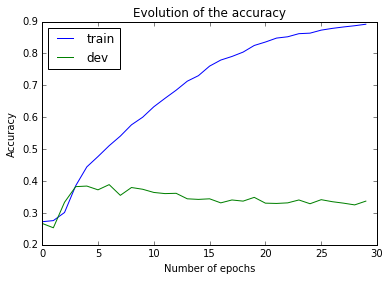

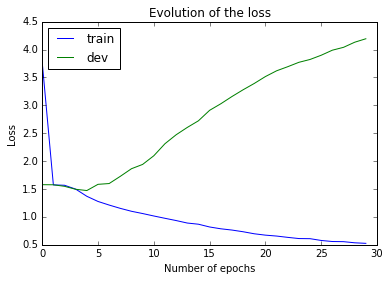

In [72]:
# 8 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers import Embedding,Dense,Activation,Conv1D,MaxPooling1D,GlobalAveragePooling1D,Dropout,LeakyReLU
from keras.optimizers import Adam

MAX_NB_WORDS = 10000
MAX_SENT     = 30

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)

tokenizer.fit_on_texts(x_train+x_dev+x_test)
x_tok = tokenizer.texts_to_sequences(x_train+x_dev+x_test)

word_index = tokenizer.word_index

x_train_tok = x_tok[:len(x_train)]
x_dev_tok  = x_tok[len(x_train):len(x_train)+len(x_dev)]
x_test_tok  = x_tok[len(x_train)+len(x_dev):]

x_train_pad2 = pad_sequences(x_train_tok, maxlen=MAX_SENT)
x_dev_pad2   = pad_sequences(x_dev_tok, maxlen=MAX_SENT)
x_test_pad2  = pad_sequences(x_test_tok,maxlen=MAX_SENT)

num_words   = min(MAX_NB_WORDS,len(word_index))+1
embedding_matrix = np.zeros((num_words,embed_dim))

for word,i in word_index.items():
    if i > num_words:
        continue
    emb_vector = word2vec_en.get(word) #if word isn't in word2vec_en, we return a NoneType
    if emb_vector is not None:
        embedding_matrix[i] = emb_vector

filters     = 128
kernel_size = 5
pool_size   = 3

model_2 = Sequential()
model_2.add(Embedding(num_words,embed_dim,weights = [embedding_matrix],trainable = True))
# model_2.add(Embedding(num_words,embed_dim))

model_2.add(Conv1D(filters=filters,kernel_size=kernel_size,padding='valid',kernel_regularizer=regularizers.l2(0.01)))
model_2.add(LeakyReLU(alpha=0.3))
model_2.add(MaxPooling1D(pool_size=pool_size))

model_2.add(Conv1D(filters=filters,kernel_size=kernel_size,padding='valid',kernel_regularizer=regularizers.l2(0.1)))
model_2.add(LeakyReLU(alpha=0.3))
model_2.add(GlobalAveragePooling1D())

model_2.add(Dropout(0.5))
model_2.add(Dense(n_classes,activation = 'softmax'))

loss_classif    = 'categorical_crossentropy'
optimizer       = Adam(lr=0.001)
metrics_classif = ['accuracy']
model_2.compile(loss=loss_classif,optimizer=optimizer,metrics=metrics_classif)
model_2.summary()

# # ADAPT CODE BELOW
bs = 64
n_epochs = 30

#Checkpoint
filepath="weights_CONV-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=False, mode='max')
# earlystopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10,restore_best_weights=True)
callbacks_list = [checkpoint]

history_2 = model_2.fit(x_train_pad2, y_train, batch_size=bs, epochs=n_epochs, callbacks=callbacks_list,
                        validation_data=(x_dev_pad2, y_dev))

"""
Accuracy plots
"""

plt.plot(history_2.history['acc'])
plt.plot(history_2.history['val_acc'])
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.title('Evolution of the accuracy')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

"""
Loss plots
"""

plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.title('Evolution of the loss')
plt.legend(['train', 'dev'], loc='upper left')


###Output####
model_2.load_weights("weights_CONV-20-0.35.hdf5")
output2 = model_2.predict(x_test_pad2)

file = open(os.path.join(PATH_TO_DATA, "Conv_y_test_sst.txt"),"w") 
for elem in output2:
    file.write(str(elem)+'\n')
file.close()